In [1]:
from savejupyterdata import load, save
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
import statsmodels.api as sm

import os
import time
import re
import numba

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [2]:
%matplotlib widget

In [3]:
load()

FigureCanvasNbAgg()

2019-06-09_22:42.jupyterData is loaded


In [2]:
fd_pos = pd.read_csv('pos_definitions.csv')
fd_neg = pd.read_csv('neg_definitions.csv')
into_pos = pd.read_csv('pos_featureValues.csv')
into_neg = pd.read_csv('neg_featureValues.csv')


fd_pos.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
fd_neg.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
into_pos.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)
into_neg.rename(columns={'Unnamed: 0':'feature_index'}, inplace=True)

def remove_first_two_num(col):
    if re.match('^[0-9]{2}.*.mzXML', col):
        return col[2:-6].replace('_pos', '').replace('_neg', '')
    elif 'QC' in col:
        return col[:-6].replace('_pos', '').replace('_neg', '')
    else:
        return col.replace('_pos', '').replace('_neg', '')
    
into_pos.rename(columns=remove_first_two_num, inplace=True)
into_neg.rename(columns=remove_first_two_num, inplace=True)

In [184]:
class ChromatographData():
    """
    Objects contain data and transform method
    """
    def __init__(self, data, polarity='postive', feature_index_col='parse'):
        """
        :data: pd.DataFrame
        :polarity: 'positive' or 'negative'
        :feature_index_col: col identifier if there is
        """
        #self._polartity
        if not any([polarity.lower() in two for two in ['positive', 'negative']]):
            raise ValueError(f'invalid polarity parameter!{polarity}')
        if polarity.lower() in 'positive':
            self._polarity = 'Positive'
        else:
            self._polarity = 'Negative'
        
        #self._data and self._index
        if feature_index_col =='parse':
            self._index = data.loc[:, data.dtypes==np.object]
            if self._index.shape[1]>1:
                raise MoreThanOneIndexCol(
                    f'data has {self._index.shape[1]} object columns! (must be 1)')
            self._data = data.loc[:, data.dtypes!=np.object]
            
        elif isinstance(feature_index_col, int):
            self._index = pd.DataFrame(data.iloc[:, feature_index_col]).rename(
                columns={0:data.columns[feature_index_col]})
            self._data = data.loc[:, data.columns != data.columns[feature_index_col]]
        
        elif isinstance(feature_index_col, str):
            self._index = pd.DataFrame(data.loc[:, feature_index_col]).rename(
                columns={0:feature_index_col})
            self._data = data.loc[:, data.columns != feature_index_col]
            
        else:
            raise TypeError('feature_index_col must be "parse", int or str!')
        
        #get indices list about QCs, filters and test samples
        self._qc_indices, self._filter_indices, self._test_indices = self._get_index()
        self._categories, self._simple_columns = self._classify()      
        
    def __repr__(self):
        """
        print Data status
        include data shape, process history
        """
        return(f'''Chromatograph data:\n
        data shape {self._data.shape}''')
    
    def _get_index(self):
        qcs = []
        filters = []
        tests = []
        for i, col in enumerate(self._data.columns):
            if col.startswith('QC'):
                qcs.append(i)
            elif col.startswith('Fi'):
                filters.append(i)
            else:
                tests.append(i)
        return [pd.Index(indices) for indices in [qcs, filters, tests]]
    
    @property
    def df(self):
        return self._data
    
    def _classify(self):
        cates = defaultdict(list)
        simple_columns = []
        
        for i, col in enumerate(self._data.columns):
            if 'cond' in col:
                cates[col[:-1]].append(i)
                simple_columns.append(col[:-1])
            else:
                cates[re.match('(.*)_.*', col)[1]].append(i)
                simple_columns.append(re.match('(.*)_.*', col)[1])
                
        return cates, simple_columns
    
    def fill_na_by_categories(self):
        s = time.time()
        df = self.df
        cates, cols = [], []
        for c, r in self._categories.items():
            cates.append(c)
            cols.append(r)
        df_vals = df.values
        for cate, col in zip(cates, cols):
            data = df_vals[:, col]
            df_vals[:, col] = self._fill_fast(data)

        df_vals = self._fill_all(df_vals)
        df = pd.DataFrame(df_vals, index=self._data.index,
                         columns=self._data.columns)
        self._data = df
    
    @staticmethod
    @numba.njit
    def _fill_fast(data):
        for i in range(data.shape[0]):
            temp = data[i,:]
            med = np.nanmedian(temp)
            temp[np.isnan(temp)] = med
            data[i, :] = temp
        return data
    
    @staticmethod
    @numba.njit
    def _fill_all(data):
        for i in range(data.shape[0]):
            temp = data[i,:]
            minimum = np.nanmin(temp)/(3**.5)
            temp[np.isnan(temp)] = minimum
            data[i, :] = temp
        return data

    def get_df(self, cate):
        return self._data.iloc[:, self._categories[cate]]
    
    def balance_runtime(self, center, method='LinearSVR'):
        svr = LinearSVR(max_iter=10000000)
        rsd = self.RSD_QCs()
        indices=rsd[rsd<0.3].index.values
        qc = self._data.iloc[indices, self._qc_indices]
        
        center = self._data.iloc[indices, center][:,None]
        medians = (center/qc).median().values
        svr.fit(self._qc_indices.values.reshape(-1,1),
               medians)
        
        coefs = svr.predict(np.arange(self._data.shape[1]).reshape(-1, 1))
        self._data = self._data*coefs
    
    def filter_by_RSD(self, threshold=0.3):
        rsd = self.RSD_QCs()
        new_indices = rsd[rsd<threshold].index
        self._data = self._data.loc[new_indices,:]
        
    def RSD_QCs(self):
        qc = self.get_df('QC')
        return qc.std(1)/qc.mean(1)
    
    def agg_cates(self):
        res = []
        for cate, cols in self._categories.items():
            temp = self._data.iloc[:, cols].median(1)
            res.append(pd.DataFrame(temp, columns=[cate]))
        return pd.concat(res, axis=1).sort_index(axis=1)

In [185]:
pos = ChromatographData(into_pos, 'positive')

pos.fill_na_by_categories()

pos.balance_runtime(27)

pos.filter_by_RSD()

In [674]:
df= pos.agg_cates()

In [675]:
df = df.iloc[:, df.columns.str.startswith('Fi')]

In [676]:
def comb_two(seq):
    if len(seq) < 2:
        raise ValueError('seq must have two or more elements')
    if len(seq) == 2:
        return [[seq[0],seq[1]]]
    else:
        temp = comb_two(seq[:-1])
        for s in seq[:-1]:
            temp.append([s, seq[-1]])
        return temp

done 1 done 2 done 3 done 4 done 5 done 6 done 7 done 8 done 9 done 10 done 11 done 12 done 13 done 14 done 15 

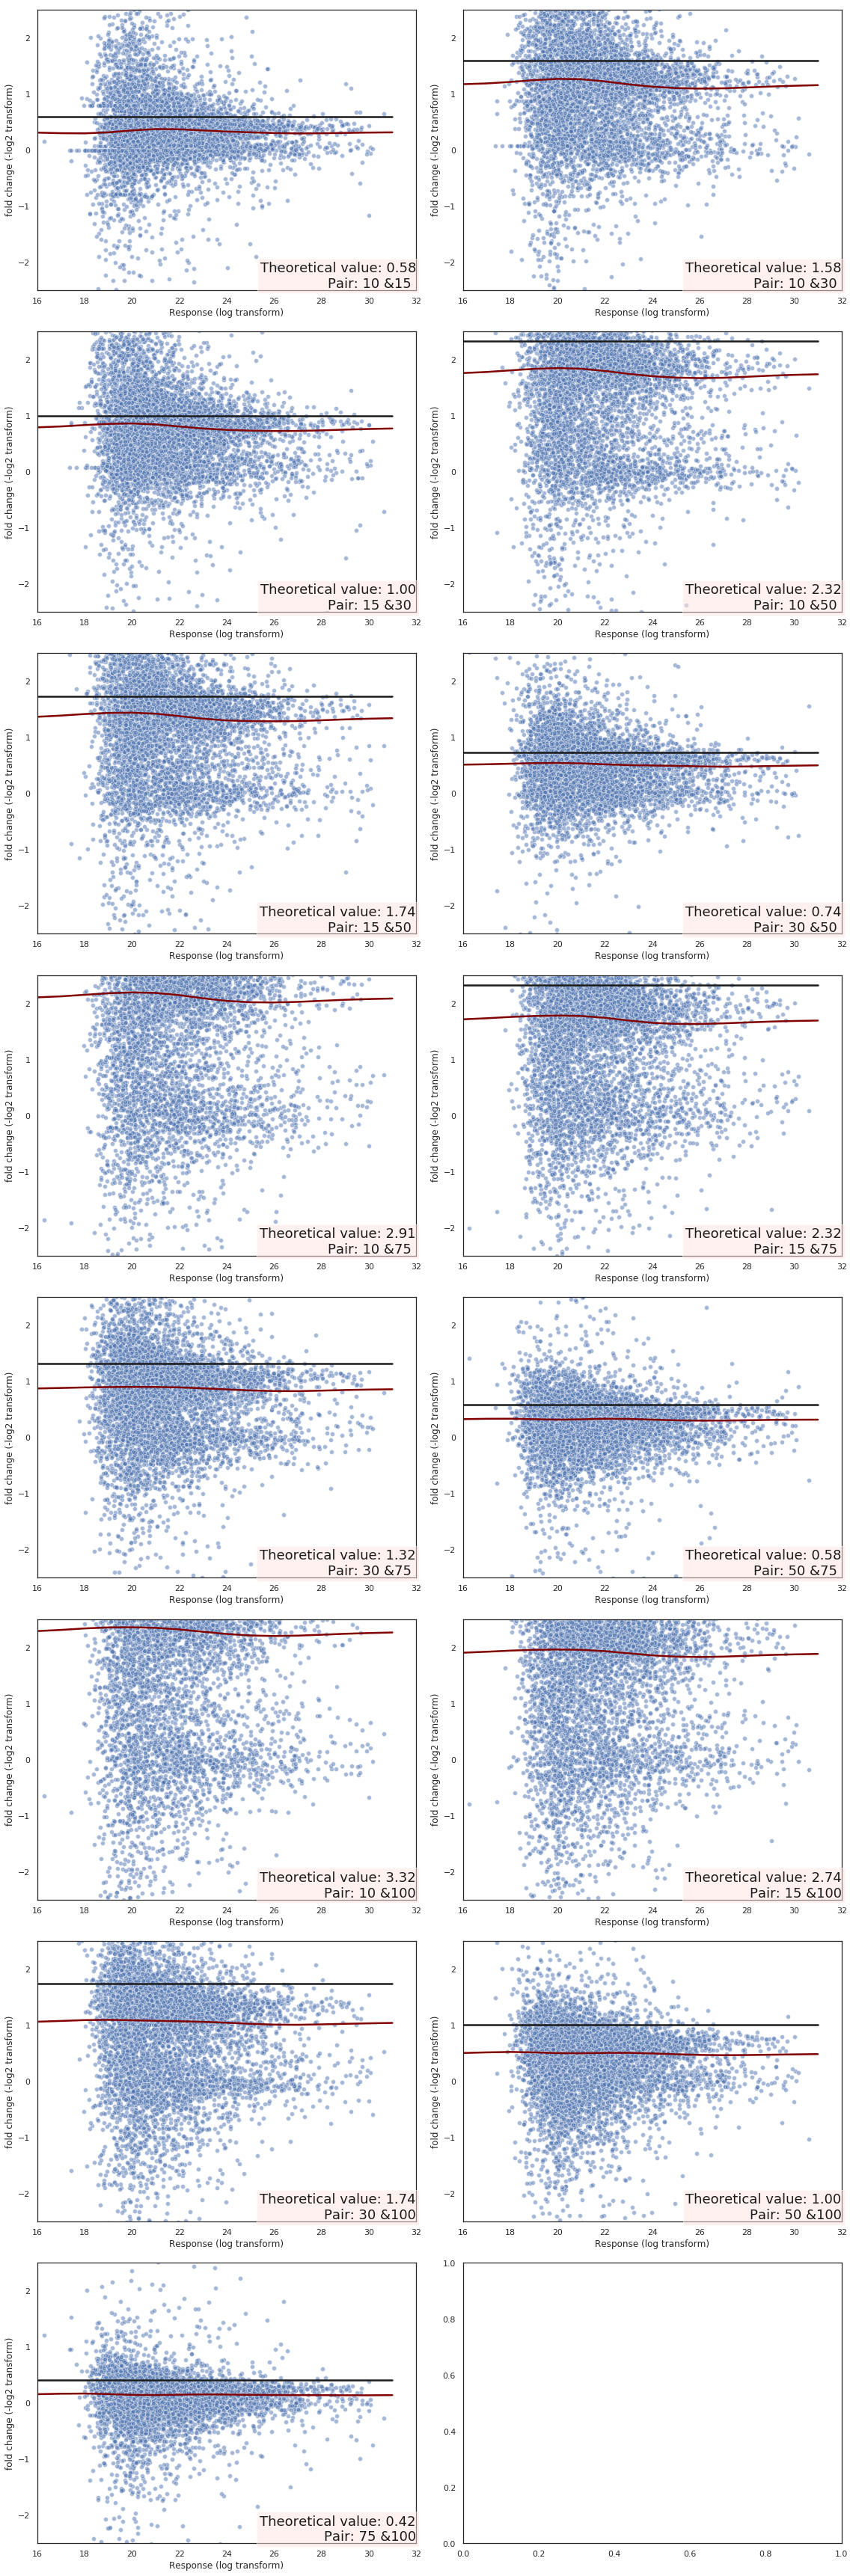

In [831]:
combs = comb_two(df.columns.values)
fig, axs = plt.subplots(8,2,figsize=(16,48))
axs = axs.ravel()

for i, comb in enumerate(combs):
    ax = axs[i]
    left, right = comb

    fd_change = np.log2(df.loc[:, right]/df.loc[:, left])
    X = np.log2(pos.get_df('QC').median(1)).values

    sns.scatterplot(X, fd_change, ax=ax, alpha=.5)

    svr = SVR(gamma='scale', C=0.001)
    svr.fit(X.reshape(-1,1), fd_change)
    x0 = np.arange(15,32)
    sns.lineplot(x0, svr.predict(x0.reshape(-1,1)), ax=ax, color='maroon', linewidth=2.5)

    theory = np.log2(int(right[-3:])/int(left[-3:]))
    sns.lineplot(x0, np.ones(len(x0))*theory, color='k', ax=ax, linewidth=2.5, zorder=10)
    ax.set_xlim(16,32)
    ax.set_ylim(-2.5, 2.5)
    ax.text(1, 0.05, f'Theoretical value: {theory:.2f}\nPair: {int(left[-3:]):<3}&{int(right[-3:]):<3}', 
           color='k', fontsize=18,
           bbox=dict(facecolor='mistyrose', alpha=.5), transform=ax.transAxes,
           ha='right', va='center')
    ax.set_xlabel('Response (log transform)')
    ax.set_ylabel('fold change (-log2 transform)')
    print(f'done {i+1}', end=' ')
plt.tight_layout()

In [835]:
final = df.loc[((ols['coefficient']>0.5) & (ols['P-value'] < 0.05)), :]

In [16]:
combs = comb_two(final.columns.values)

done 1 done 2 done 3 done 4 done 5 done 6 done 7 done 8 done 9 done 10 done 11 done 12 done 13 done 14 done 15 

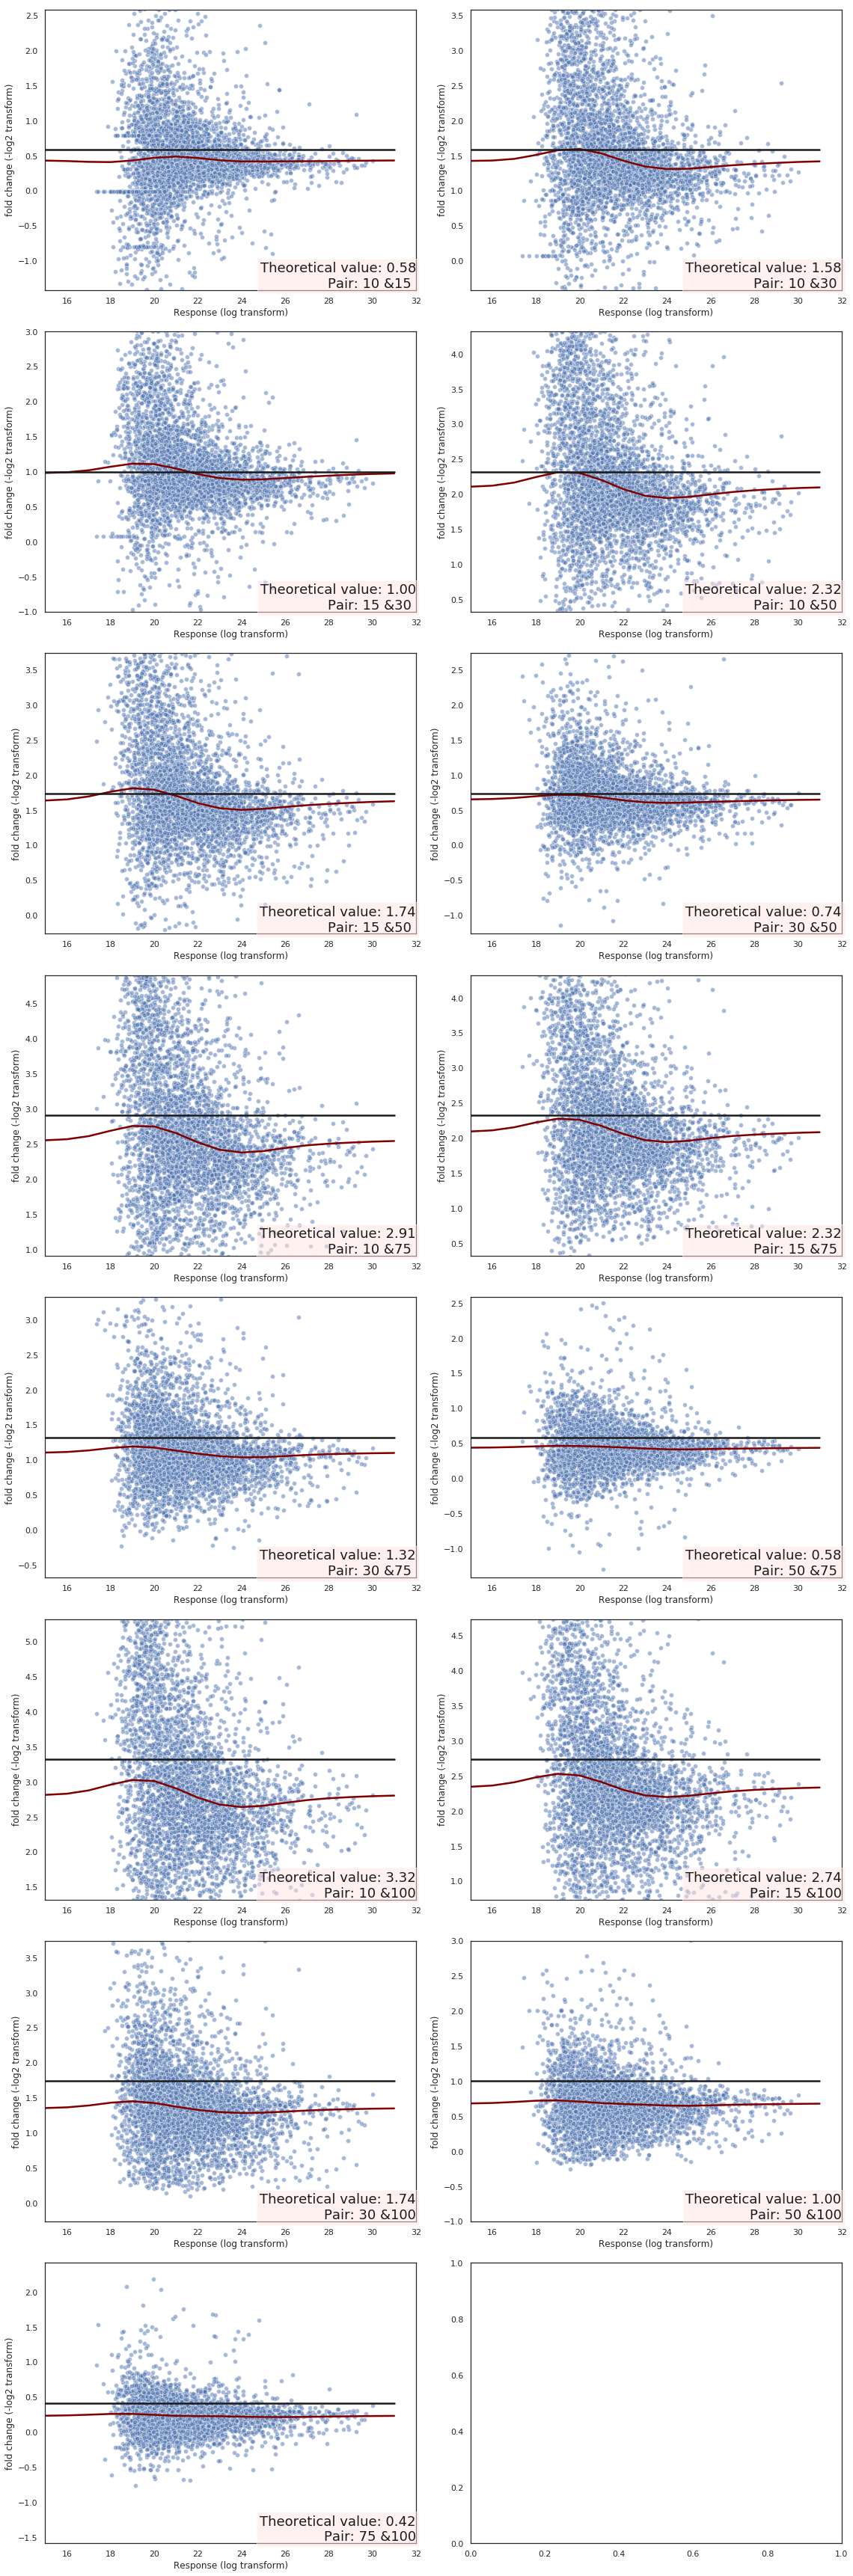

In [840]:
combs = comb_two(final.columns.values)
fig, axs = plt.subplots(8,2,figsize=(16,48))
axs = axs.ravel()

for i, comb in enumerate(combs):
    ax = axs[i]
    left, right = comb

    fd_change = np.log2(final.loc[:, right]/final.loc[:, left])
    X = np.log2(pos.get_df('QC').loc[final.index, :].median(1)).values

    sns.scatterplot(X, fd_change, ax=ax, alpha=.5)

    svr = SVR(gamma='scale', C=0.001)
    svr.fit(X.reshape(-1,1), fd_change)
    x0 = np.arange(15,32)
    sns.lineplot(x0, svr.predict(x0.reshape(-1,1)), ax=ax, color='maroon', linewidth=2.5)

    theory = np.log2(int(right[-3:])/int(left[-3:]))
    sns.lineplot(x0, np.ones(len(x0))*theory, color='k', ax=ax, linewidth=2.5, zorder=10)
    ax.set_xlim(15, 32)
    ax.set_ylim(theory-2,theory+2)
    ax.text(1, 0.05, f'Theoretical value: {theory:.2f}\nPair: {int(left[-3:]):<3}&{int(right[-3:]):<3}', 
           color='k', fontsize=18,
           bbox=dict(facecolor='mistyrose', alpha=.5), transform=ax.transAxes,
           ha='right', va='center')
    ax.set_xlabel('Response (log transform)')
    ax.set_ylabel('fold change (-log2 transform)')
    print(f'done {i+1}', end=' ')
plt.tight_layout()

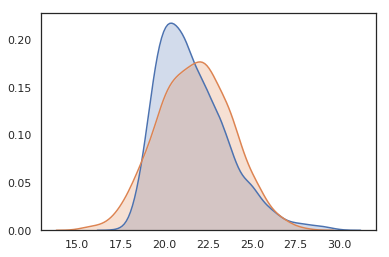

In [152]:
sns.kdeplot(X, shade=True)
sns.kdeplot(np.random.normal(X.mean(), X.std(), 1000), shade=True)

In [163]:
gau = stats.gaussian_kde(X)

In [164]:
s = gau.pdf(X)

Text(0, 0.5, 'fold change (-log2 transform)')

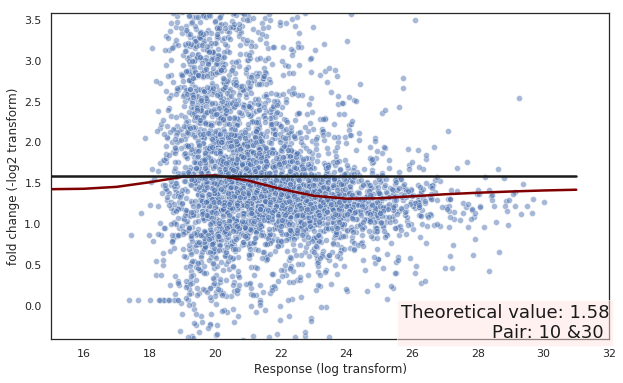

In [183]:
plt.figure(figsize=(10,6))
ax=plt.gca()
comb = combs[1]

left, right = comb

fd_change = np.log2(final.loc[:, right]/final.loc[:, left])
X = np.log2(pos.get_df('QC').loc[final.index, :].median(1)).values

sns.scatterplot(X, fd_change, ax=ax, alpha=.5)
gau =stats.gaussian_kde(X)
weights = 1/gau.pdf(X)
weights = np.log2(weights)

weights = MinMaxScaler().fit_transform(weights.reshape(-1,1)).ravel()

svr = SVR(gamma='scale', C=0.001)
#svr.fit(X.reshape(-1,1), fd_change, sample_weight=weights)
svr.fit(X.reshape(-1,1), fd_change)
x0 = np.arange(15,32)
sns.lineplot(x0, svr.predict(x0.reshape(-1,1)), ax=ax, color='maroon', linewidth=2.5)

theory = np.log2(int(right[-3:])/int(left[-3:]))
sns.lineplot(x0, np.ones(len(x0))*theory, color='k', ax=ax, linewidth=2.5, zorder=10)
ax.set_xlim(15, 32)
ax.set_ylim(theory-2,theory+2)
ax.text(1, 0.05, f'Theoretical value: {theory:.2f}\nPair: {int(left[-3:]):<3}&{int(right[-3:]):<3}', 
       color='k', fontsize=18,
       bbox=dict(facecolor='mistyrose', alpha=.5), transform=ax.transAxes,
       ha='right', va='center')
ax.set_xlabel('Response (log transform)')
ax.set_ylabel('fold change (-log2 transform)')

In [184]:
from sklearn.decomposition import PCA

In [264]:
%matplotlib widget

In [10]:
plt.figure(figsize=(8,8))
ax = plt.gca()
sns.kdeplot(np.log2(pos.get_df("QC").loc[final.index].median(1)), ols.loc[final.index, 'coefficient'], cmap='Blues', shade=True, shade_lowest=False, ax=ax)
sns.kdeplot(np.log2(pos.get_df("QC").loc[final.index].median(1)), ols.loc[final.index, 'coefficient'], color='k', ax=ax,alpha=.5)

svr = SVR(gamma='scale')
svr.fit(np.log2(pos.get_df("QC").loc[final.index].median(1)).values.reshape(-1,1), ols.loc[final.index,:'coefficient'].values.ravel())
sns.lineplot(np.linspace(17,32,1000), svr.predict(np.linspace(17,32,1000).reshape(-1,1)), color='maroon', ax=ax)

FigureCanvasNbAgg()

In [21]:
for i, comb in enumerate(combs):
    temp = (final.loc[:, comb[1]]/final.loc[:, comb[0]]).median()
    print(f'{comb[1][-3:]}<>{comb[0][-3:]}: {temp:.2f}, theory: {int(comb[1][-3:])/int(comb[0][-3:]):.2f}')

015<>010: 1.36, theory: 1.50
030<>010: 2.69, theory: 3.00
030<>015: 1.96, theory: 2.00
050<>010: 4.27, theory: 5.00
050<>015: 3.07, theory: 3.33
050<>030: 1.57, theory: 1.67
075<>010: 5.85, theory: 7.50
075<>015: 4.22, theory: 5.00
075<>030: 2.14, theory: 2.50
075<>050: 1.36, theory: 1.50
100<>010: 6.97, theory: 10.00
100<>015: 5.03, theory: 6.67
100<>030: 2.55, theory: 3.33
100<>050: 1.60, theory: 2.00
100<>075: 1.18, theory: 1.33


In [26]:
dff.shape

(4170, 53)

In [148]:
vals = StandardScaler().fit_transform(dff.T)
pca = PCA(n_components=5).fit_transform(vals)
pca = pd.DataFrame(pca, index=pos._simple_columns)
pca['Categories'] = pca.index
pca.index = np.arange(pca.shape[0])

In [9]:
plt.figure(figsize=(12,6))
data = pca.loc[~pca['Categories'].str.startswith('Fi'), :]
sns.scatterplot(0, 1, data=data, hue='Categories', style='Categories', s=300)
for row in data.iterrows():
    plt.gca().text(data.loc[row[0], 0], data.loc[row[0], 1], row[0]+1, fontsize=15)
    

FigureCanvasNbAgg()

In [8]:
plt.figure(figsize=(12,6))
data = pca.loc[(pca['Categories'].str.startswith('Fi')) | (pca['Categories'].str.startswith('QC')), :]
sns.scatterplot(0, 1, data=data, hue='Categories', style='Categories', s=300)
for row in data.iterrows():
    plt.gca().text(data.loc[row[0], 0], data.loc[row[0], 1], row[0]+1, fontsize=15)
    

FigureCanvasNbAgg()

In [40]:
for col in df.columns:
    temp = (df.loc[:, col]/df.iloc[:, 3]).median()
    print(f'{col}: {temp:.2f}, theory:{int(col[-3:])/50:.2f}')

Filter_010: 0.29, theory:0.20
Filter_015: 0.38, theory:0.30
Filter_030: 0.69, theory:0.60
Filter_050: 1.00, theory:1.00
Filter_075: 1.26, theory:1.50
Filter_100: 1.42, theory:2.00


In [46]:
df_balance = dff.copy()

In [46]:
qc_medians = df_balance.loc[:, df_balance.columns.str.match('QC_[0-9]')].median(1)
for col in df_balance.columns:
    temp = (df_balance.loc[:, col]/qc_medians.values).median()
    #print(f'{col}, {temp:.2f}')
    df_balance.loc[:, col] /= temp

In [150]:
vals = StandardScaler().fit_transform(df_balance.T)
pca = PCA(n_components=5).fit_transform(vals)
pca = pd.DataFrame(pca, index=pos._simple_columns)
pca['Categories'] = pca.index
pca.index = np.arange(pca.shape[0])

# balance using median

In [7]:
plt.figure(figsize=(12,6))
#data = pca.loc[(pca['Categories'].str.startswith('Fi')) | (pca['Categories'].str.startswith('QC')), :]
data = pca
sns.scatterplot(0, 1, data=data, hue='Categories', 
                #style='Categories', 
                s=300)
for row in data.iterrows():
    plt.gca().text(data.loc[row[0], 0], data.loc[row[0], 1], row[0]+1, fontsize=15)

FigureCanvasNbAgg()

In [6]:
plt.figure(figsize=(8,8))
ax = plt.gca()
sns.kdeplot(np.log2(pos.get_df("QC").loc[final.index].median(1)), ols.loc[final.index, 'coefficient'], cmap='Blues', shade=True, shade_lowest=False, ax=ax)
sns.kdeplot(np.log2(pos.get_df("QC").loc[final.index].median(1)), ols.loc[final.index, 'coefficient'], color='k', ax=ax,alpha=.5)

svr = SVR(gamma='scale')
svr.fit(np.log2(pos.get_df("QC").loc[final.index].median(1)).values.reshape(-1,1), ols.loc[final.index,:'coefficient'].values.ravel())
sns.lineplot(np.linspace(17,32,1000), svr.predict(np.linspace(17,32,1000).reshape(-1,1)), color='maroon', ax=ax)

FigureCanvasNbAgg()

# balance using SVR

In [84]:
svr.predict(np.log2(qc_medians).values.reshape(-1,1)).max()

1.0279085279201912

In [137]:
df_svr = dff.copy()

medians = df_svr.loc[:, df_svr.columns.str.match('QC_[0-9]')].median(1).values

for col in df_svr.columns:
    temp = (df_svr.loc[:, col]/medians).median()
    #print(f'{col}, {temp:.2f} theory:{int(col[-3:])/50:.2f}')
    df_svr.loc[:, col] /= temp
    df_svr.loc[:, col] *= ols.loc[df_svr.index,'coefficient']

In [5]:
vals1 = StandardScaler().fit_transform(df_svr.T)
pca1 = PCA(n_components=5).fit_transform(vals1)
pca1 = pd.DataFrame(pca1, index=pos._simple_columns)
pca1['Categories'] = pca1.index
pca1.index = np.arange(pca1.shape[0])

plt.figure(figsize=(8,5))
#data = pca.loc[(pca['Categories'].str.startswith('Fi')) | (pca['Categories'].str.startswith('QC')), :]
data = pca1
sns.scatterplot(0, 1, data=data, hue='Categories', 
                #style='Categories', 
                s=300)
for row in data.iterrows():
    plt.gca().text(data.loc[row[0], 0], data.loc[row[0], 1], row[0]+1, fontsize=15)

FigureCanvasNbAgg()

In [4]:
vals2 = StandardScaler().fit_transform(df_balance.T)
pca2 = PCA(n_components=5).fit_transform(vals2)
pca2 = pd.DataFrame(pca2, index=pos._simple_columns)
pca2['Categories'] = pca2.index
pca2.index = np.arange(pca2.shape[0])

plt.figure(figsize=(8,5))
#data = pca.loc[(pca['Categories'].str.startswith('Fi')) | (pca['Categories'].str.startswith('QC')), :]
data = pca2
sns.scatterplot(0, 1, data=data, hue='Categories', 
                #style='Categories', 
                s=300)
for row in data.iterrows():
    plt.gca().text(data.loc[row[0], 0], data.loc[row[0], 1], row[0]+1, fontsize=15)

FigureCanvasNbAgg()

['Filter_015', 'Filter_075']
2.321928094887362


Text(0, 0.5, 'fold change (-log2 transform)')

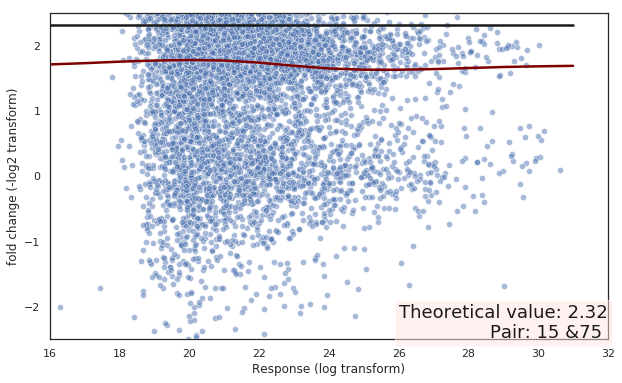

In [830]:
plt.figure(figsize=(10,6))
ax=plt.gca()
comb = combs[7]
print(comb)
left, right = comb

fd_change = np.log2(df.loc[:, right]/df.loc[:, left])
X = np.log2(pos.get_df('QC').median(1)).values

sns.scatterplot(X, fd_change, ax=ax, alpha=.5)

svr = SVR(gamma='scale', C=0.001)
svr.fit(X.reshape(-1,1), fd_change)
x0 = np.arange(15,32)
sns.lineplot(x0, svr.predict(x0.reshape(-1,1)), ax=ax, color='maroon', linewidth=2.5)

theory = np.log2(int(right[-3:])/int(left[-3:]))
print(theory)
sns.lineplot(x0, np.ones(len(x0))*theory, color='k', ax=ax, linewidth=2.5, zorder=10)
ax.set_xlim(16,32)
ax.set_ylim(-2.5, 2.5)
ax.text(1, 0.05, f'Theoretical value: {theory:.2f}\nPair: {int(left[-3:]):<3}&{int(right[-3:]):<3}', 
       color='k', fontsize=18,
       bbox=dict(facecolor='mistyrose', alpha=.5), transform=ax.transAxes,
       ha='right', va='center')
ax.set_xlabel('Response (log transform)')
ax.set_ylabel('fold change (-log2 transform)')

['Filter_015', 'Filter_075']


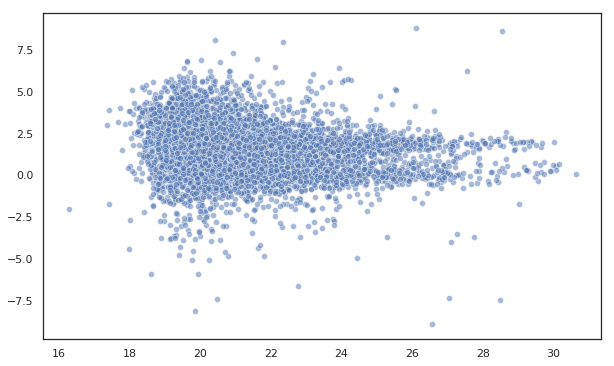

In [813]:
plt.figure(figsize=(10,6))
ax=plt.gca()
comb = combs[7]
print(comb)
left, right = comb

fd_change = np.log2(df.loc[:, right]/df.loc[:, left])
X = np.log2(pos.get_df('QC').median(1)).values

sns.scatterplot(X, fd_change, ax=ax, alpha=.5)

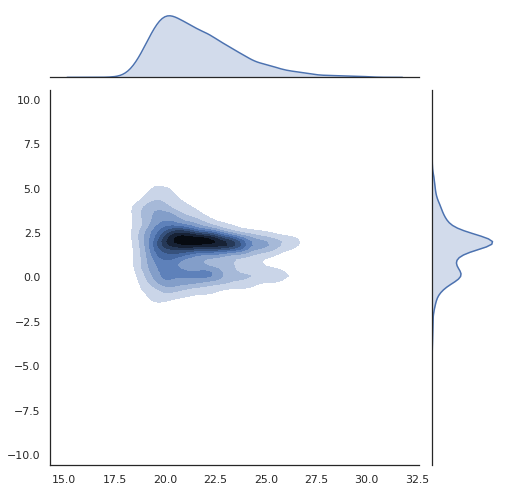

In [816]:
sns.jointplot(X, fd_change, kind='kde', height=7, shade=True, shade_lowest=False)

Text(0, 0.5, 'fold change (-log2 transform)')

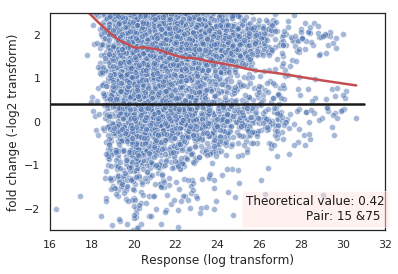

In [812]:
lo = sm.nonparametric.lowess
ax = plt.gca()
left, right = comb_two(df.columns.values)[7]

fd_change = np.log2(df.loc[:, right]/df.loc[:, left])
X = np.log2(pos.get_df('QC').median(1)).values

sns.scatterplot(X, fd_change, ax=ax, alpha=.5)

LOWESS = lo(fd_change, X, frac=.3, delta=0.1)
x0 = np.arange(15,32)
sns.lineplot(LOWESS[:,0], LOWESS[:,1], ax=ax, color='r', linewidth=2.5)

theory = np.log2(int(right[-3:]))/int(left[-3:])
sns.lineplot(x0, np.ones(len(x0))*theory, color='k', linewidth=2.5)

ax.set_xlim(16,32)
ax.set_ylim(-2.5, 2.5)
ax.text(1, 0.1, f'Theoretical value: {theory:.2f}\nPair: {int(left[-3:]):<3}&{int(right[-3:]):<3}', 
       color='k',
       bbox=dict(facecolor='mistyrose', alpha=.5), transform=ax.transAxes,
       ha='right', va='center')
ax.set_xlabel('Response (log transform)')
ax.set_ylabel('fold change (-log2 transform)')

In [550]:
coefs, pvals = [], []
sample =df.copy()
sample = sample/sample.max(1)[:, None]
for i, line in enumerate(sample.iterrows()):
    model = sm.OLS(line[1].values, sm.add_constant(np.array([.1,.15,.3,.5,.75,1])))
    results = model.fit()
    coefs.append(results.params[1])
    pvals.append(results.pvalues[1])

ols = pd.DataFrame([coefs, pvals], index=['coefficient', 'P-value'], columns=df.index).T

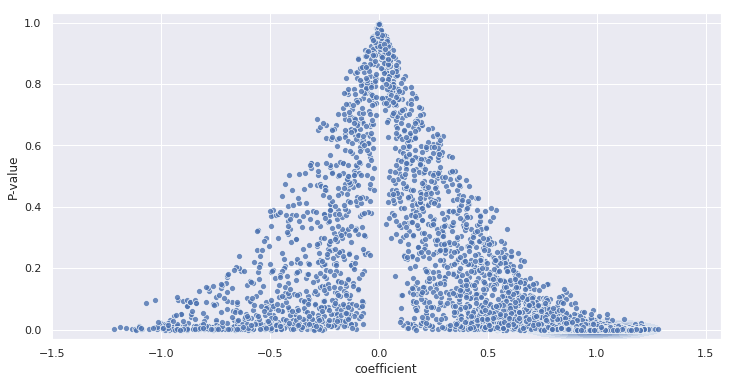

In [590]:
plt.figure(figsize=(12,6))
sns.kdeplot(ols['coefficient'], ols['P-value'], shade=True, gridsize=50, shade_lowest=False)
sns.scatterplot(x='coefficient', y='P-value', data=ols, alpha=.8)

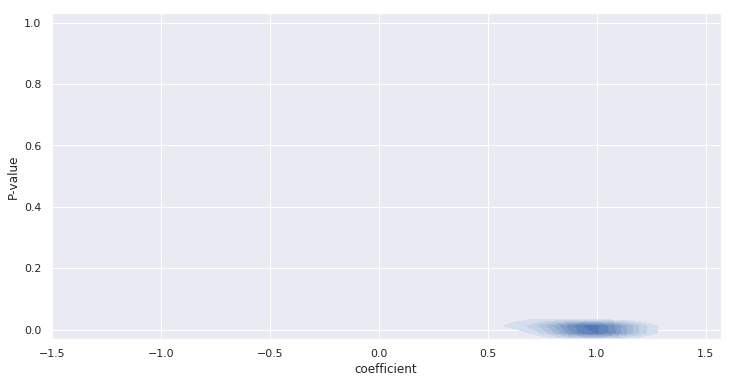

In [582]:
plt.figure(figsize=(12,6))
sns.kdeplot(ols['coefficient'], ols['P-value'], shade=True, gridsize=50, shade_lowest=False)

<Figure size 576x432 with 0 Axes>

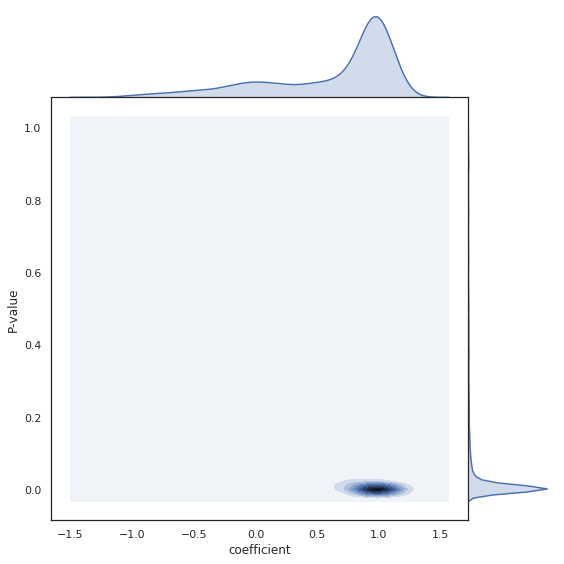

In [600]:
plt.figure(figsize=(8,6))
sns.set(style='white')
g = sns.jointplot(ols['coefficient'], ols['P-value'], kind='kde', space=0, height=8)

In [632]:
np.corrcoef(ols.coefficient, pos.get_df("QC").median(1))

array([[ 1.        , -0.03371489],
       [-0.03371489,  1.        ]])

In [634]:
np.corrcoef(ols['coefficient'], pos.get_df("QC").median(1))

array([[ 1.        , -0.04848785],
       [-0.04848785,  1.        ]])

In [644]:
import scipy.stats as stats

In [648]:
stats.pearsonr(ols['coefficient'], pos.get_df("QC").median(1))

(-0.04848785293516958, 9.719080123686201e-05)

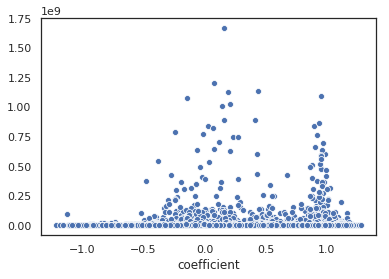

In [655]:
sns.scatterplot(ols['coefficient'], pos.get_df("QC").median(1))

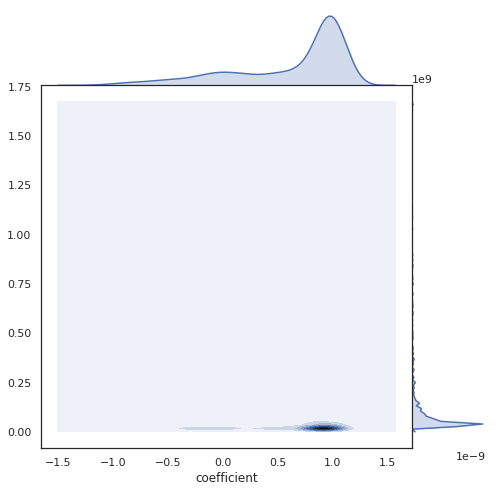

In [653]:
sns.jointplot(ols['coefficient'], pos.get_df("QC").median(1), kind='kde', space=0, height=7)

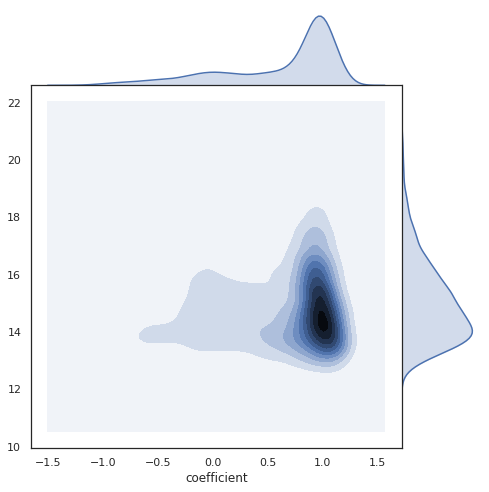

In [672]:
sns.jointplot(ols['coefficient'], np.log(pos.get_df("QC")).median(1), kind='kde', space=0, height=7)

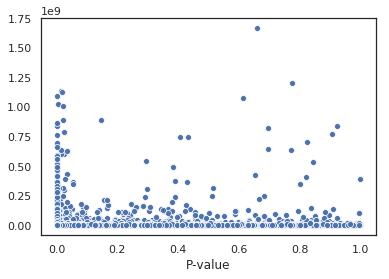

In [652]:
sns.scatterplot(ols['P-value'], pos.get_df("QC").median(1))

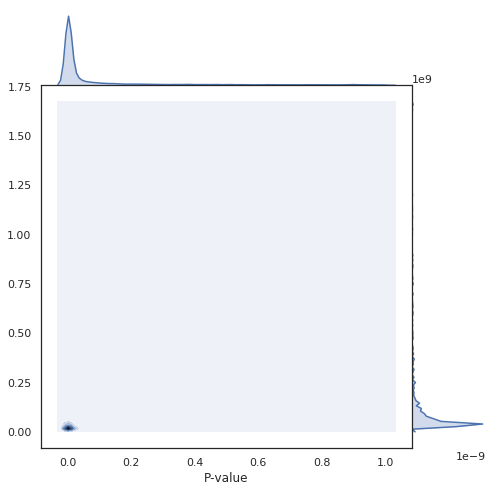

In [654]:
sns.jointplot(ols['P-value'], pos.get_df("QC").median(1), kind='kde', space=0, height=7)

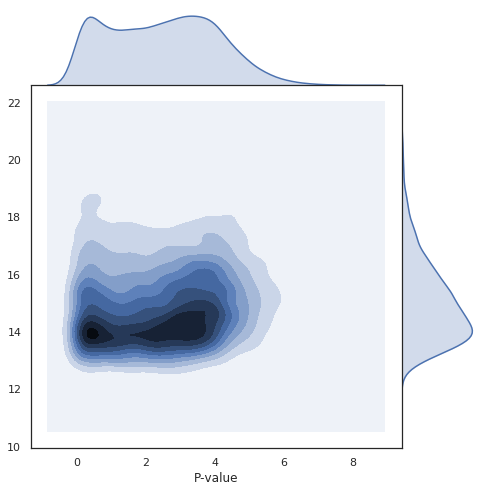

In [670]:
sns.jointplot(-np.log10(ols['P-value']), np.log(pos.get_df("QC")).median(1), kind='kde', space=0, height=7)

In [599]:
((ols['coefficient']>0.5) & (ols['P-value'] < 0.05)).sum()

4170

In [570]:
((ols['coefficient']<0) & (ols['P-value'] < 0.05)).sum()

356

In [573]:
(ols['coefficient']<0).sum()

1047

In [587]:
(ols['coefficient']>1.2).sum()

33

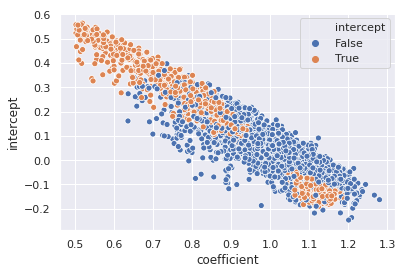

In [217]:
sns.scatterplot(pos._OLS['coefficient'], intercepts.str[0], hue=intercepts.str[1]<0.05)

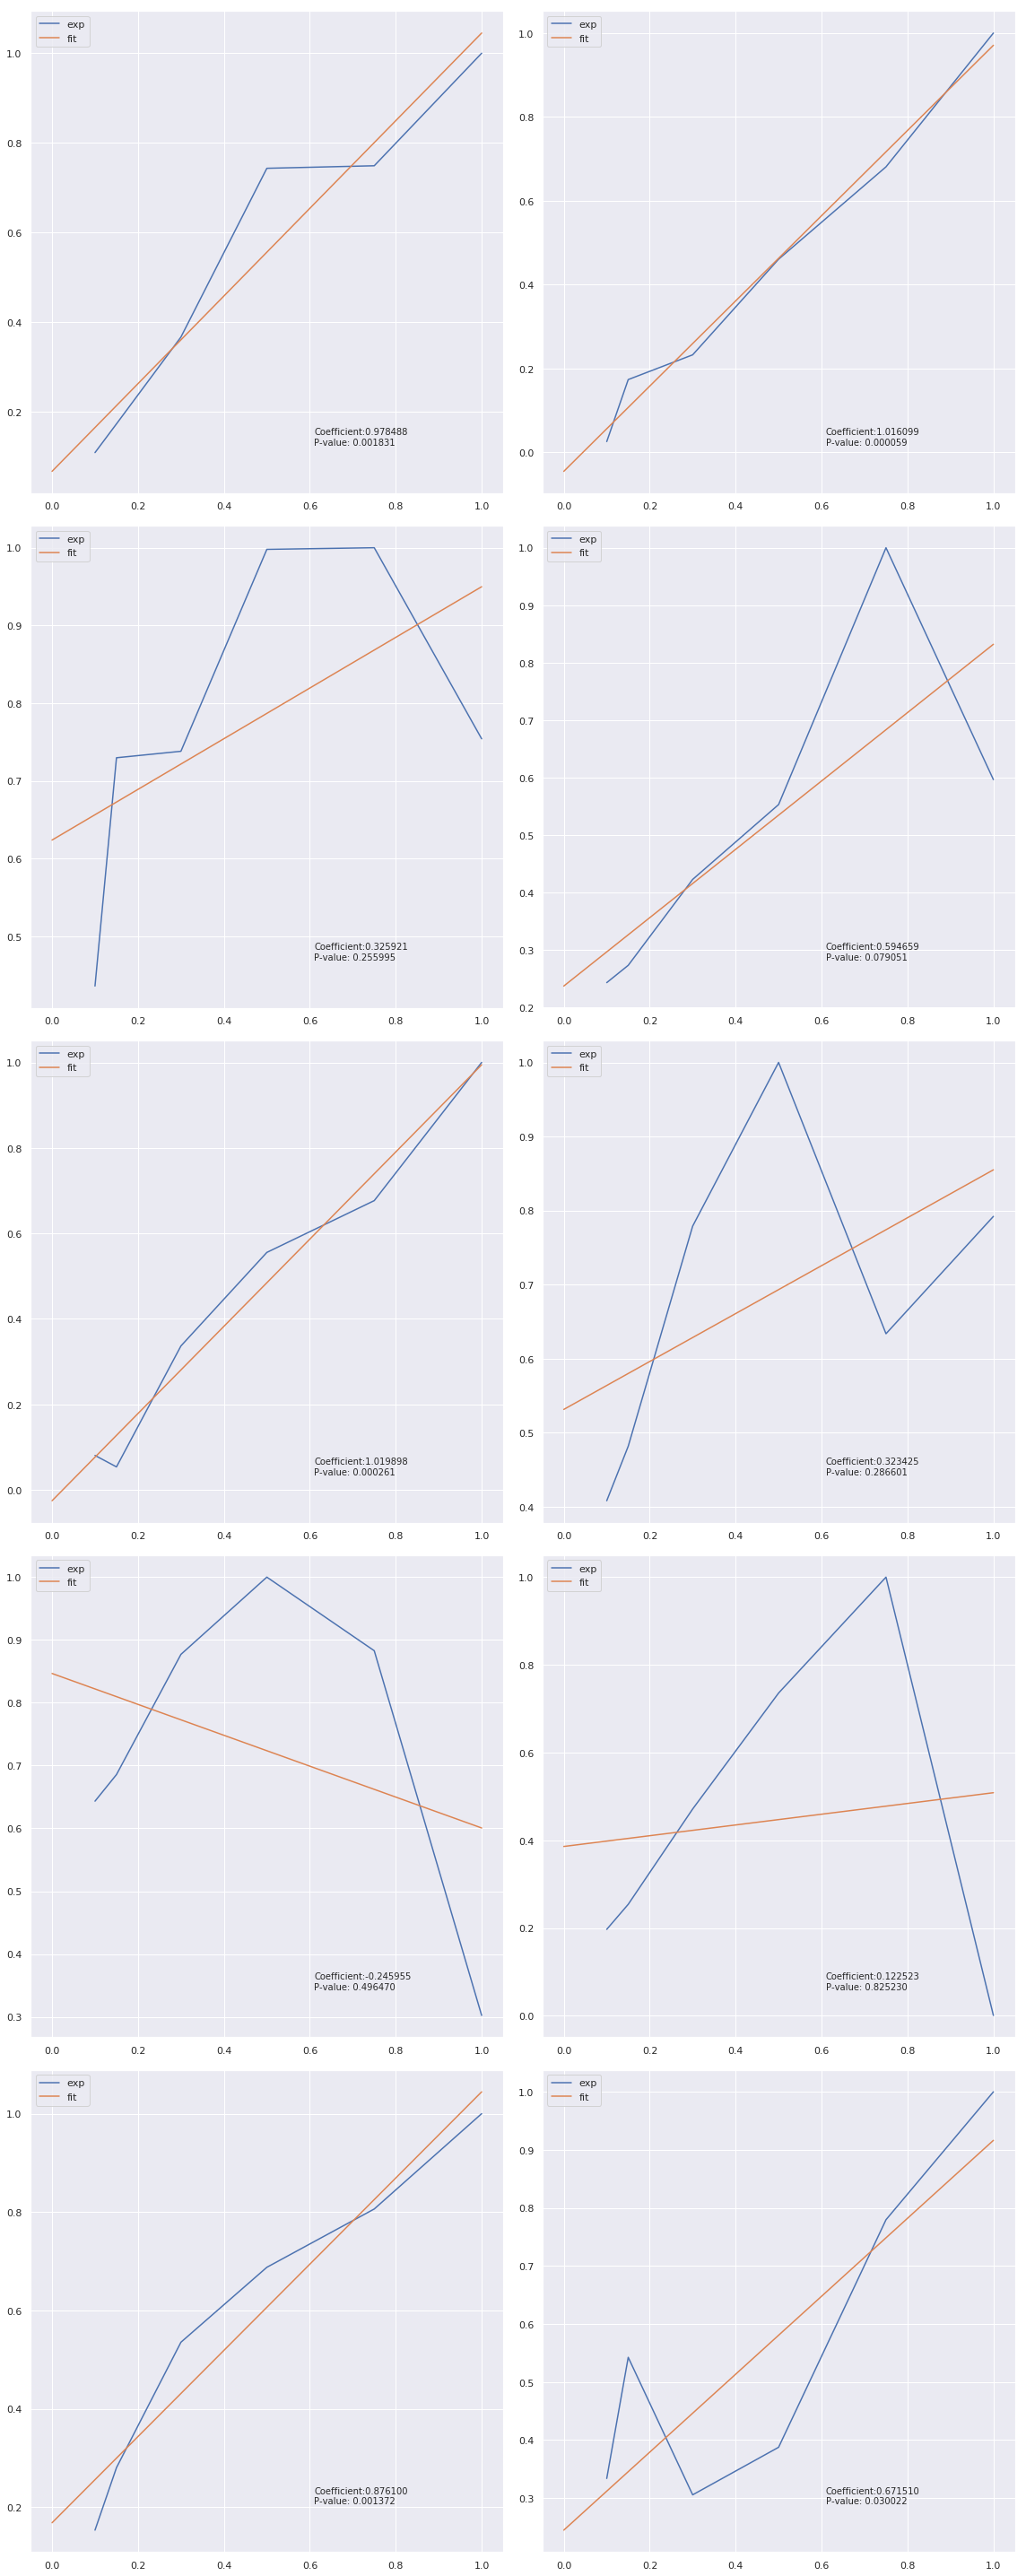

In [539]:
sample =df.sample(10)
sample = sample/sample.max(1)[:, None]

fig ,axs = plt.subplots(5,2,figsize=(16,40))
axs = axs.ravel()
for i, line in enumerate(sample.iterrows()):
    ax = axs[i]
    model = sm.OLS(line[1].values, sm.add_constant(np.array([.1,.15,.3,.5,.75,1])))
    results = model.fit()
    coefs = results.params
    pvals = results.pvalues
    ax.plot([.1,.15,.3,.5,.75,1], line[1].values, label='exp')
    ax.plot(np.linspace(0,1), np.linspace(0,1)*coefs[1]+coefs[0], label='fit')
    ax.legend(loc='upper left')
    ax.text(0.6, 0.1, f'Coefficient:{coefs[1]:3f}\nP-value: {pvals[1]:3f}', transform=ax.transAxes)
    
plt.tight_layout()

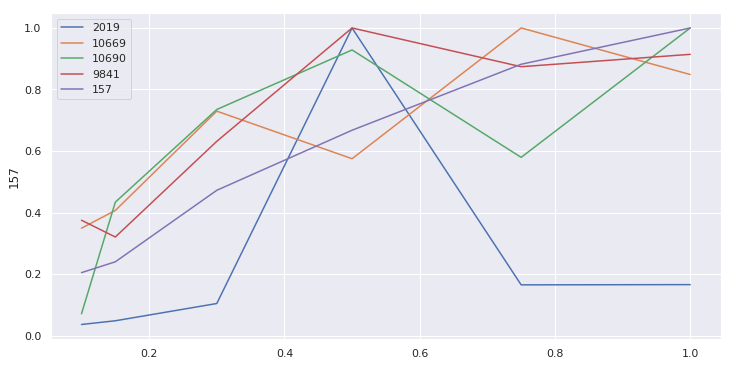

In [501]:
plt.figure(figsize=(12,6))
sample =df.sample(5)
sample = sample/sample.max(1)[:, None]
for line in sample.iterrows():
    sns.lineplot(x=[.1,.15,.3,.5,.75,1], y = line[1], label=f'{line[0]}')
    model = sm.OLS(line[1].values, sm.add_constant(np.array([.1,.15,.3,.5,.75,1])))
    results = model.fit()
    coefs = results.params
    plt.text(f'{results.pvalues}, {results.params}')
plt.legend(loc='upper left')

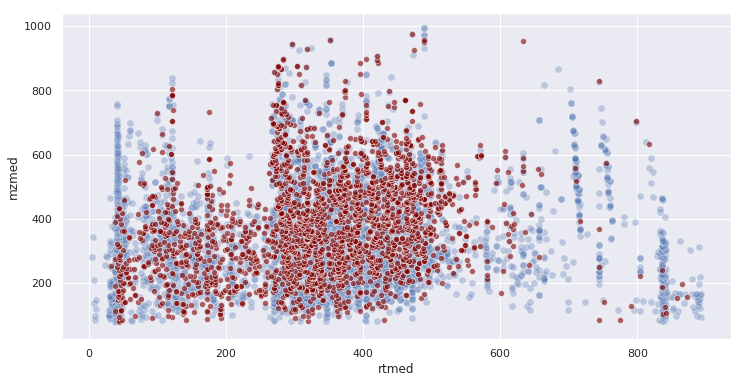

In [230]:
plt.figure(figsize=(12,6))
sns.scatterplot('rtmed', 'mzmed', data=fd.loc[~(((theory-0.1)<medians) & (medians<(theory+0.1))), :], s=50, alpha=.3)
sns.scatterplot('rtmed', 'mzmed', data=fd.loc[((theory-0.1)<medians) & (medians<(theory+0.1)), :], color='maroon', alpha=.6)

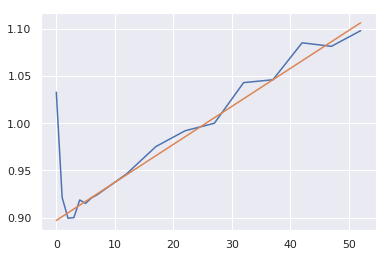

In [55]:
svr = LinearSVR(max_iter=1000000)
svr.fit(pos._qc_indices.values.reshape(-1,1), (qc['QC_4'][:, None] / pd.concat([qc_cond, qc], axis=1)).median().values)

plt.plot(pos._qc_indices.values, (qc['QC_4'][:, None] / pd.concat([qc_cond, qc], axis=1)).median().values)
plt.plot(np.arange(53), svr.predict(np.arange(0, 53).reshape(-1,1)))

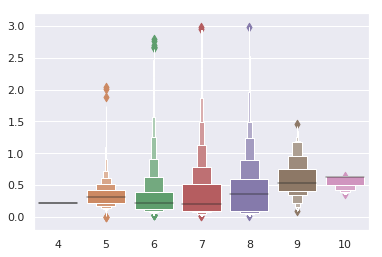

In [39]:
sns.boxenplot(x=mag, y=rsd)

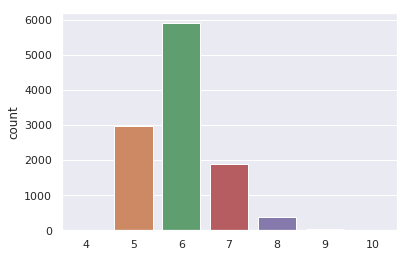

In [40]:
sns.countplot(mag)

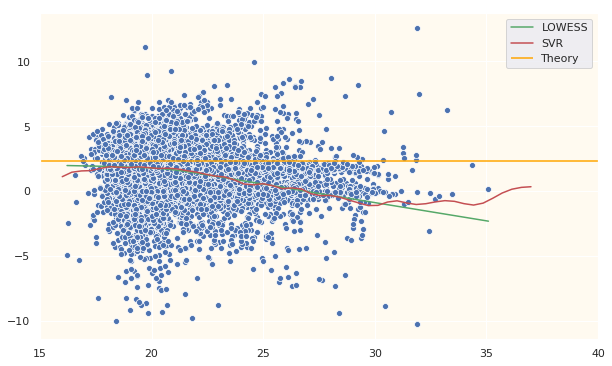

In [557]:
fig, ax = plt.subplots(figsize=(10,6))
sns.scatterplot(np.log2(qc.median(1)), m, ax=ax)
ax.set_facecolor('floralwhite')
loe = sm.nonparametric.lowess(m, np.log2(qc.median(1)), )
sns.lineplot(loe[:, 0], loe[:, 1], color='g', label='LOWESS')
sns.lineplot(np.linspace(16, 37), svr.predict(np.linspace(16, 37).reshape(-1,1)), color='r', label='SVR')
ax.hlines(np.log2(5), 0, 100, colors='orange', label='Theory')
ax.set_xlim(15,40)
ax.legend()

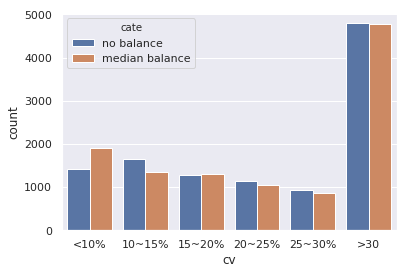

In [177]:
sns.countplot(x='cv', hue='cate', data=rsd)

In [158]:
df = pos.df.copy()
df.columns = pos._simple_columns

df = df.loc[s.index,:]

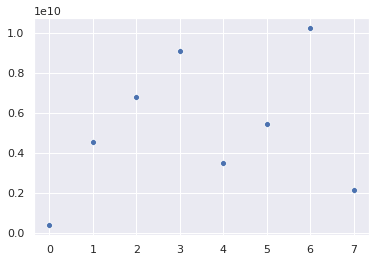

In [175]:
sns.scatterplot(cols, temp.values)

In [310]:
for m in np.unique(mag):
    temp = qc.iloc[mag==m, :]
    print(f'Magnitude {m}, result:')
    print((temp['QC_4'][:, None]/temp).median())
    print('~~~~~~\n')

Magnitude 4, result:
QC_1    0.824825
QC_2    0.701874
QC_3    0.557675
QC_4    1.000000
QC_5    0.824825
QC_6    0.824825
QC_7    0.824825
QC_8    1.163220
QC_9    0.824825
dtype: float64
~~~~~~

Magnitude 5, result:
QC_1    0.951126
QC_2    0.993328
QC_3    1.000000
QC_4    1.000000
QC_5    1.084558
QC_6    1.063368
QC_7    1.136308
QC_8    1.101872
QC_9    1.112941
dtype: float64
~~~~~~

Magnitude 6, result:
QC_1    0.953142
QC_2    0.978711
QC_3    0.994202
QC_4    1.000000
QC_5    1.041625
QC_6    1.043734
QC_7    1.078527
QC_8    1.074602
QC_9    1.093763
dtype: float64
~~~~~~

Magnitude 7, result:
QC_1    0.933009
QC_2    0.962879
QC_3    0.986592
QC_4    1.000000
QC_5    1.030615
QC_6    1.046341
QC_7    1.079709
QC_8    1.085119
QC_9    1.102169
dtype: float64
~~~~~~

Magnitude 8, result:
QC_1    0.940575
QC_2    0.966752
QC_3    0.973512
QC_4    1.000000
QC_5    1.016193
QC_6    1.033737
QC_7    1.046620
QC_8    1.076093
QC_9    1.086312
dtype: float64
~~~~~~

Magnitude 9, re

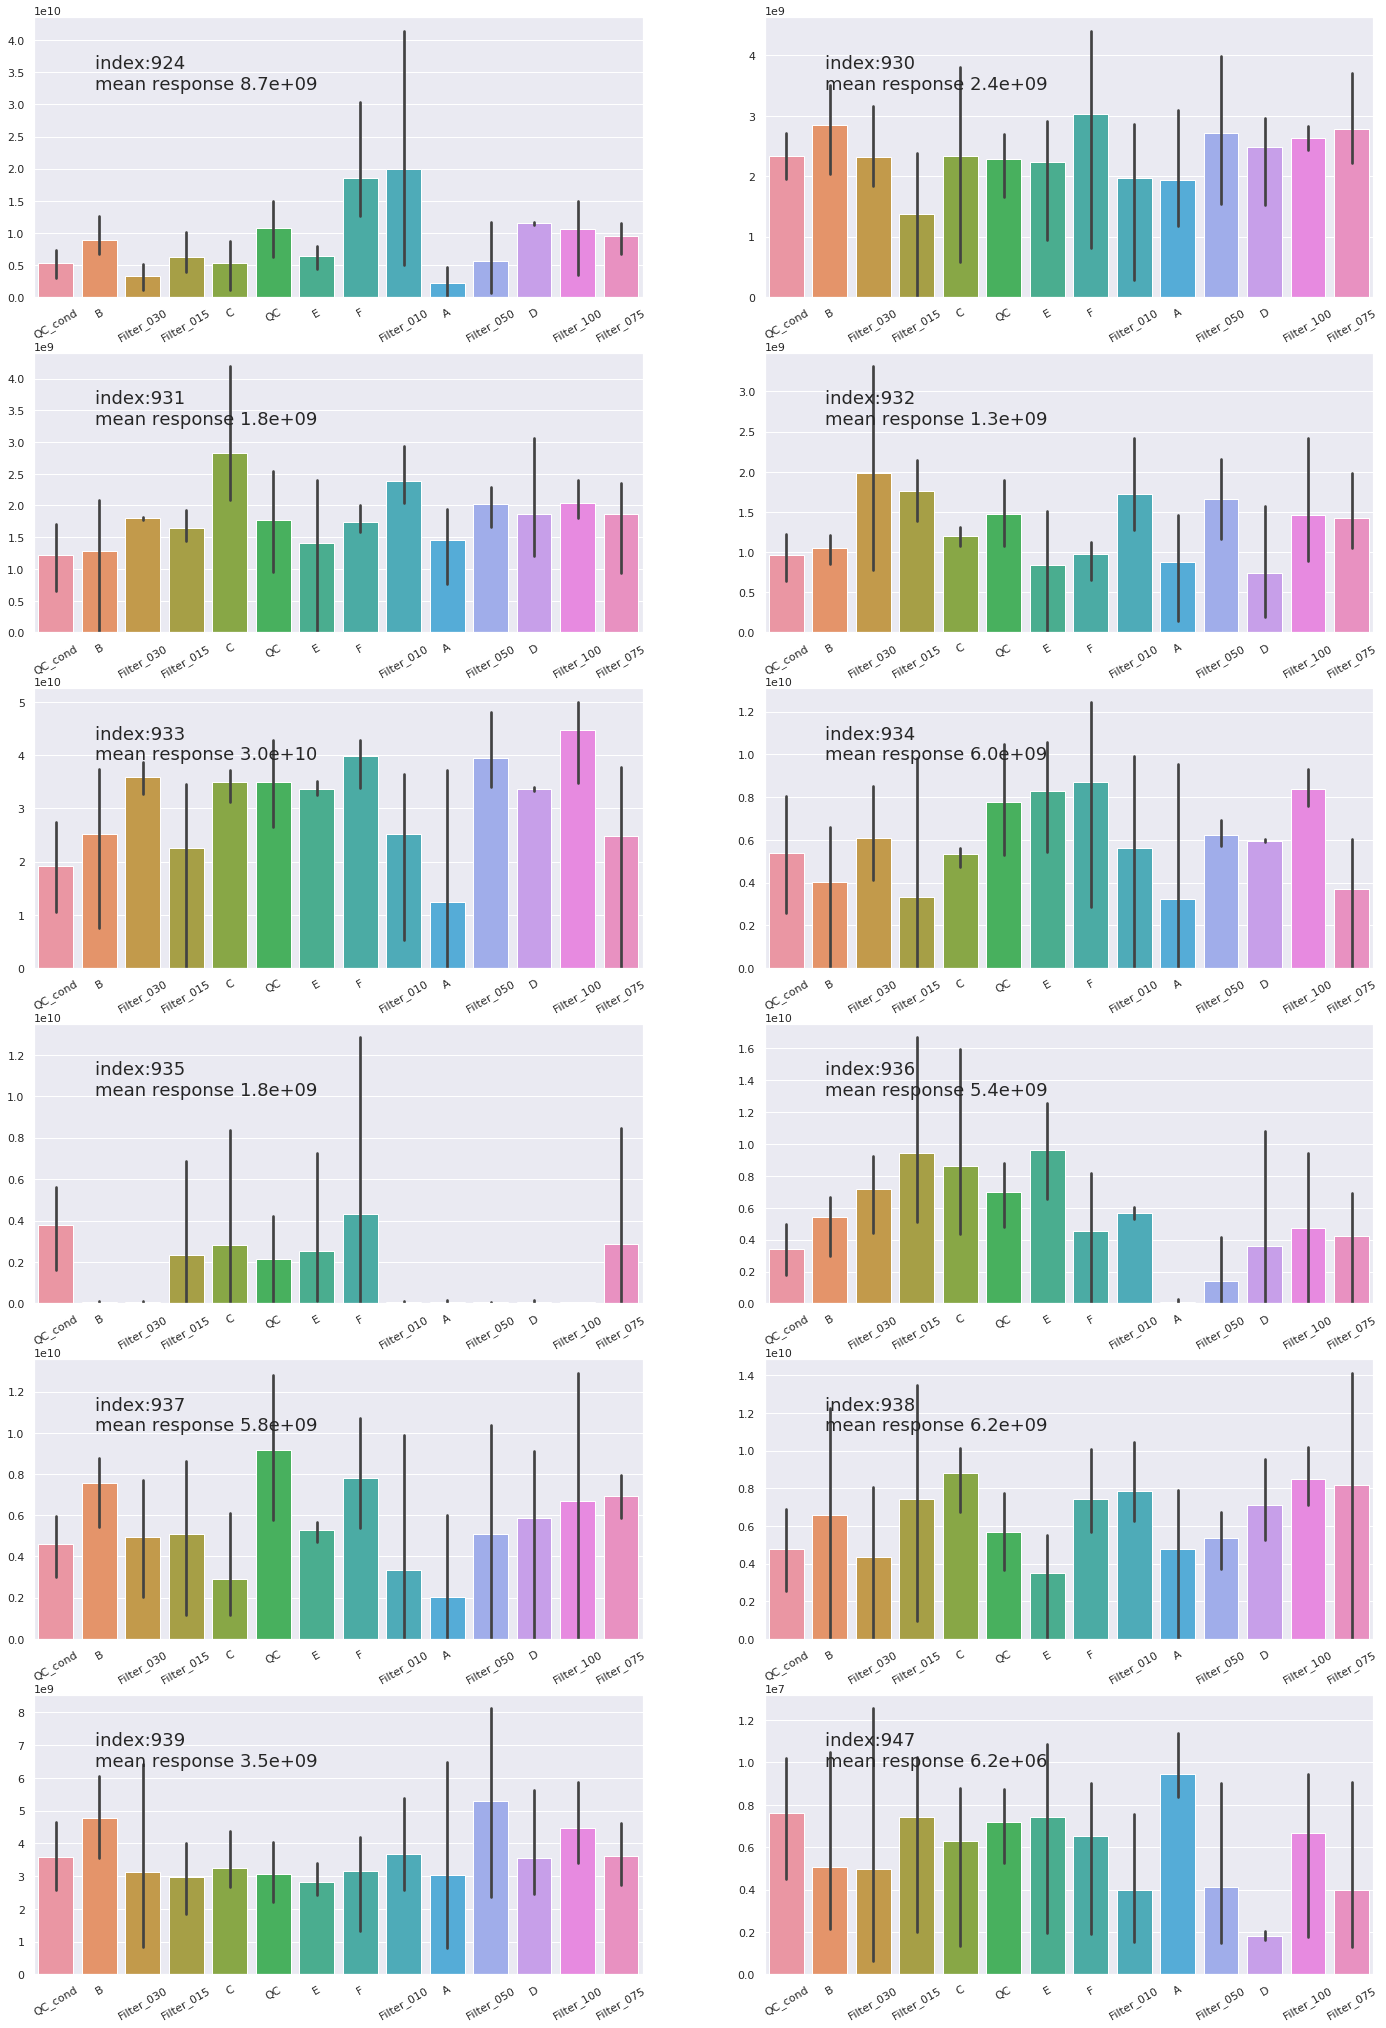

In [255]:
fig, axs = plt.subplots(6, 2, figsize=(24, 36))
axs = axs.ravel()
for i in range(len(s.index)):
    temp = pd.DataFrame(df.iloc[i, :])
    temp['cate'] = temp.index
    temp.columns = ['val', 'cate']
    sns.barplot(x='cate', y='val', data=temp, ax=axs[i])
    axs[i].tick_params('x', rotation=30)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].text(0.1, 0.8, f'index:{s.index[i]} \nmean response {temp.mean().values[0]:.1e}', 
                fontsize=18, ha='left', va='center', transform=axs[i].transAxes)

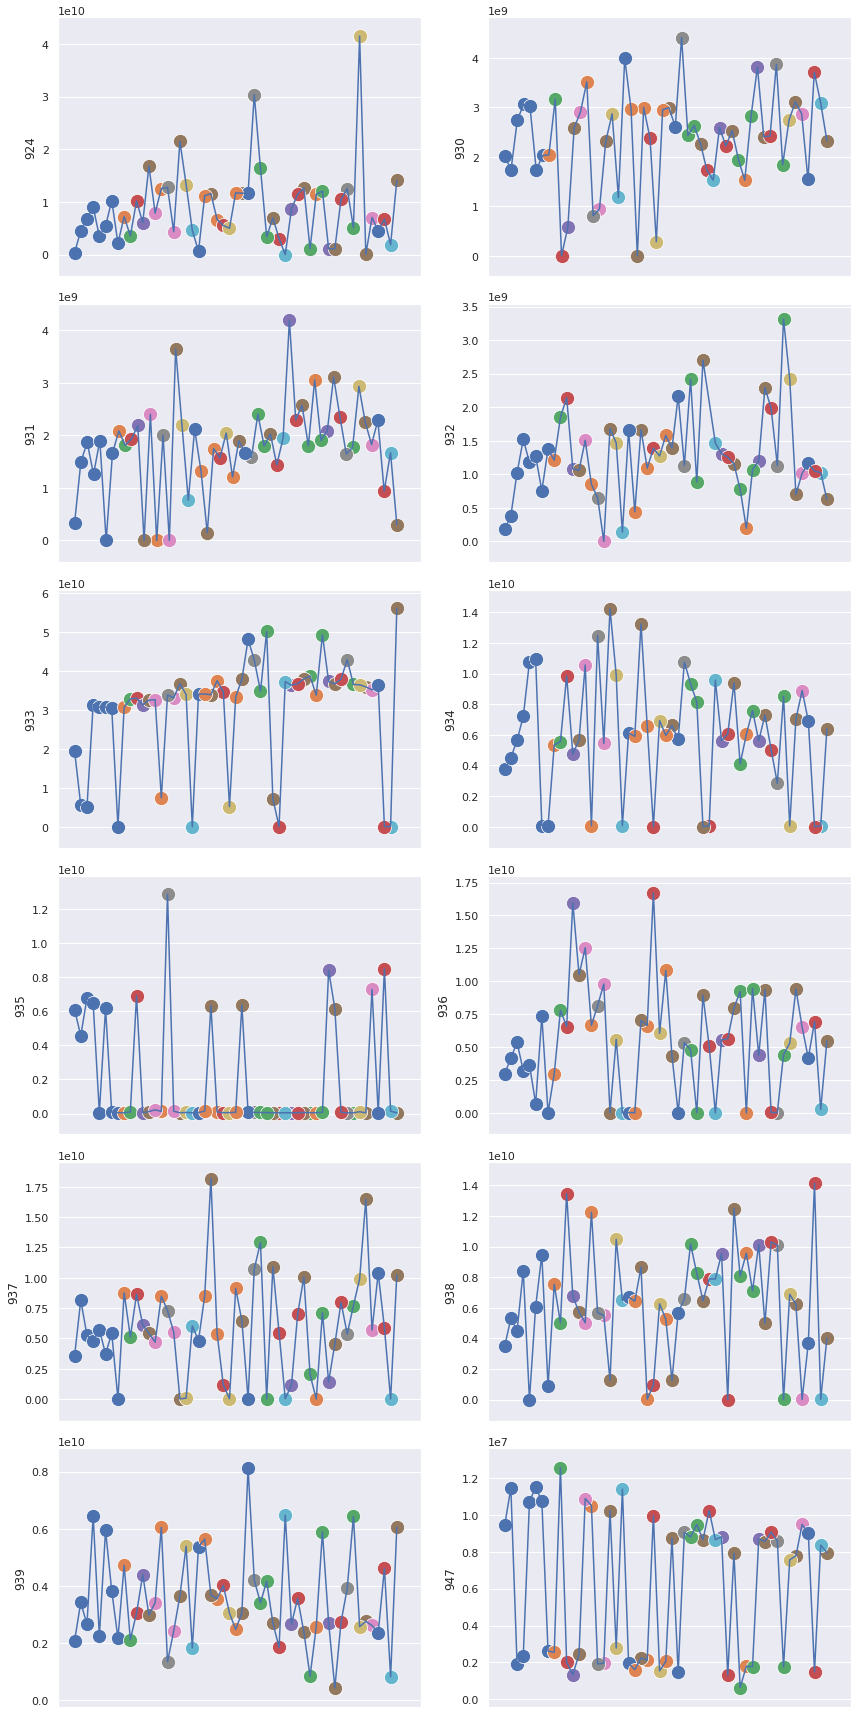

In [186]:
fig, axs = plt.subplots(6, 2, figsize=(12, 24))
axs = axs.ravel()
for i in range(len(s.index)):
    for cate, cols in pos._categories.items():
        temp = df.iloc[i, cols]
        sns.scatterplot(cols, temp.values, ax=axs[i], s=200)
    sns.lineplot(np.arange(df.shape[1]), df.iloc[i, :], ax=axs[i])
    axs[i].set_xticks([])
plt.tight_layout()

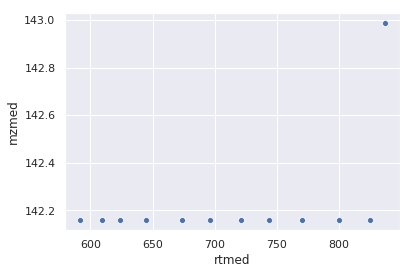

In [140]:
s = fd_pos[(fd_pos['mzmed']>142) & (fd_pos['mzmed']<143)&(fd_pos['rtmed']>500)]

sns.scatterplot(x='rtmed', y='mzmed', data=s)

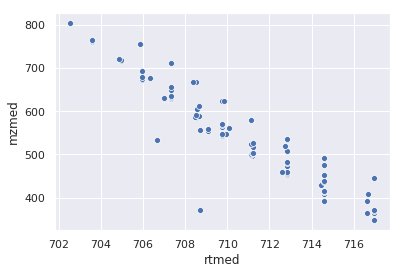

In [256]:
t = fd_pos[(fd_pos['rtmed']>700) & (fd_pos['rtmed']<720) & (fd_pos['mzmed']>300)]
sns.scatterplot(x='rtmed', y='mzmed', data=t)

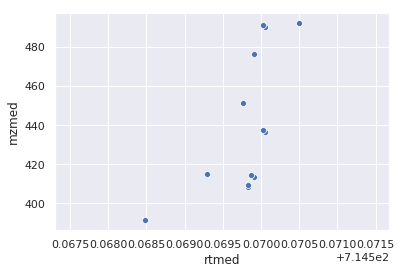

In [258]:
t = fd_pos[(fd_pos['rtmed']>714.5) & (fd_pos['rtmed']<715) & (fd_pos['mzmed']>300)]
sns.scatterplot(x='rtmed', y='mzmed', data=t)

In [266]:
df = pos.df.copy()
df.columns = pos._simple_columns

df = df.loc[t.index,:]

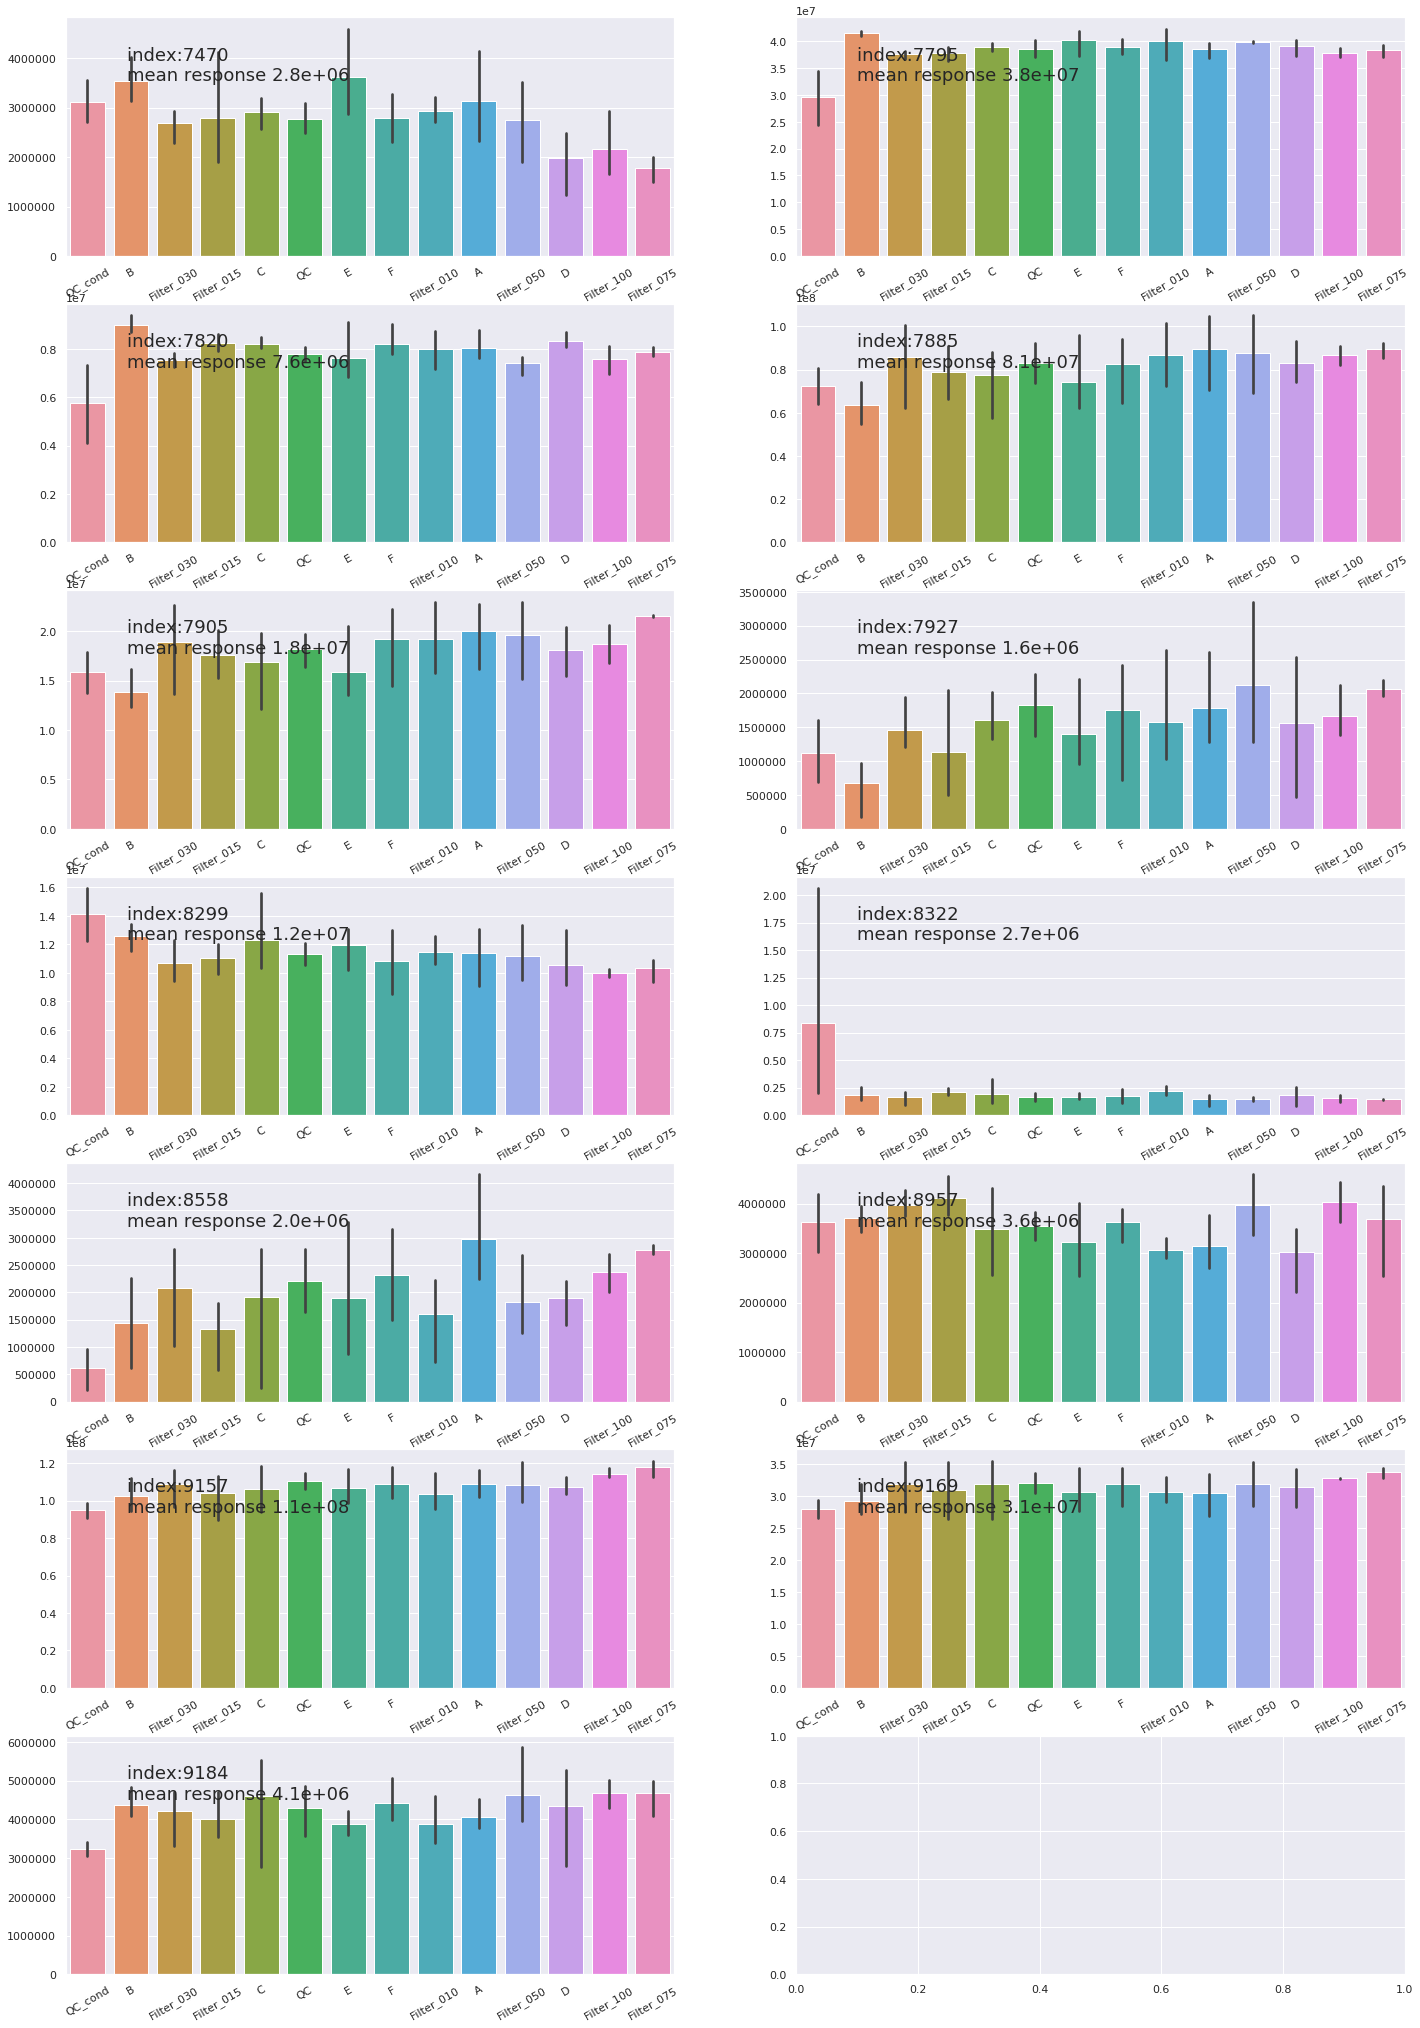

In [273]:
fig, axs = plt.subplots(7, 2, figsize=(24, 36))
axs = axs.ravel()
for i in range(len(t.index)):
    temp = pd.DataFrame(df.iloc[i, :])
    temp['cate'] = temp.index
    temp.columns = ['val', 'cate']
    sns.barplot(x='cate', y='val', data=temp, ax=axs[i])
    axs[i].tick_params('x', rotation=30)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].text(0.1, 0.8, f'index:{t.index[i]} \nmean response {temp.mean().values[0]:.1e}', 
                fontsize=18, ha='left', va='center', transform=axs[i].transAxes)

(-1, 12000)

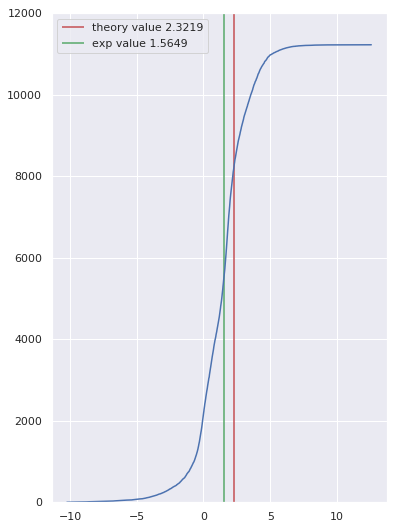

In [508]:
fig, ax = plt.subplots(1,1,figsize=(6,9))
sns.lineplot(m,np.arange(m.size))
ax.vlines(np.log2(5), -1000,100000, colors='r', label=f'theory value {np.log2(5):.4f}')
ax.vlines(m.median(), -1000,100000, colors='g', label=f'exp value {m.median():.4f}')
ax.legend()
ax.set_ylim(-1,12000)